# Introduction
Welcome to the first application of Probabilistic classification with Naïve Bayes!

<html>
<img src="https://www.sketchappsources.com/resources/source-image/twitterlogo_1x.png" width="20%">
</html>


# Exercise #1
In this example we will use **Twitter** as our data source to filter those tweets that are talking about a given application. This is a typical problem in probabilistic classification, where I'll use a large sample of texts corresponding to the category that I want to recognize, and another large sample of texts unrelated to that category. That way, by exploring the different word frequencies and probabilities, we'll determine if a new text belongs to one or another category, by simply looking at the existing evidence.

## Problem Statement

There is a real app called "Mandrill"

<html>
<img src="https://pipedream.com/s.v0/app_mqehAz/logo/orig" width="15%"><P>
</html>

And I want to scan twitter to capture only those tweets that mention my APP. But I don't want to read tweets talking about the animal (the actual mandrill), so I need a classifier for the tweets, that will **filter** only those which are relevant.

For this part of the problem part of the data preparation job is already done, so you start with a few hundreds tweets captured using Twitter API, with the word **Mandrill** in them. The file with tweets (`appWords.txt`) referring to the app looks like this:

    @ericcandino they're unfortunately not for sale but drop us a line via http://help.mandrill.com  a
    @gidogeek you can see what we've been working on and get a general idea of our plans at http://blo
    @guillaumepotier there are several reasons emails go to spam mind submitting a request at http://h
    @icntmx yep  we'd be glad to would you mind submitting a request at http://help.mandrill.com
    @jeremyweir if you submit a request at http://help.mandrill.com   we'll get back to you with some
    @josscrowcroft mind submitting a request via http://help.mandrill.com  with some additional detail

And the file with tweets (`otherWords.txt`) not talking about the app look like this:

    anyway  yeah  that's a thing that's going on  reincarnated mandrill-men
    arin did the spark mandrill trick i was wondering if he would :')
    audio mandrill - happy beat this is a funk song by a band who liked to w
    cannot believe i am the only one in a @mandrill 2012 #tweetfleet t-shirt
    chill penguin and spark mandrill down #megamanx
    cuando pase el bafici y se hayan perdido mandrill  mirageman  mujer metr
    de los creadores de #kiltro #mirageman y #mandrill ahora atacan con #trá

I trimmed lines for better representation, but they're arbitrarily long (within twitter limits).

As you might probably have realized, this is a **supervised problem**, and the _labeling_ of the training data has been already done, by manually separating the tweets among the two possible sets. That is the most boring part, and you always need to do so to train any classifier.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

import matplotlib
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import math

## Data Preparation

What I did to prepare the problem is to process the tweets to convert _raw_ two data files with the frequency count for each individual word on them. So, from `appWords.txt`, I generated `appFreqs.csv`, which summary is like:

In [4]:
appFile = pd.read_csv("data/appFreqs.csv", header=None, names=["word", "frequency"])
otherFile = pd.read_csv("data/otherFreqs.csv", header=None, names=["word", "frequency"])

In [5]:
appFile

,word,frequency
0,#atl,30
1,#atlanta,30
2,#bjcbranding,30
3,#buddypress,30
4,#career,30
...,...,...
852,–,90
853,‘migrate’,30
854,“mandrill”,30
855,…,540


These files contains a list of words and their frequency. We need to compute the probabilities from these frequencies (i.e., number of times a word appears w.r.t. the total count of words).

To that end, I did simply count the number of occurrences of each word (`frequency`), divided by the sum of occurrences of all the words, and put that in the column variable `probability`, but I also computed the $log$ of the probability. Remember the we can use the actual probability as:

$$ P(word) = \frac{count(word)}{\sum_{i=1}^{N}count(word_{i})} $$

or the $log(P)$, as it is more convenient to use those values than the tiny ones that the probability produces (a product of tiny values produces an even more tiny one). Remember that when using $logs$ we must sum them, instead of multiplying them. So, what we have in the variable `probability` is:

$$ logP(word) = log \left( \frac{count(word)}{\sum_{i=1}^{N}count(word_{i})} \right)  $$

In [6]:
appTotal = sum(appFile.frequency)
otherTotal = sum(otherFile.frequency)

appFile['probability'] = appFile.frequency.apply(lambda x: math.log(x/appTotal))
otherFile['probability'] = otherFile.frequency.apply(lambda x: math.log(x/otherTotal))

In [7]:
appFile

,word,frequency,probability
0,#atl,30,-7.705262
1,#atlanta,30,-7.705262
2,#bjcbranding,30,-7.705262
3,#buddypress,30,-7.705262
4,#career,30,-7.705262
...,...,...,...
852,–,90,-6.606650
853,‘migrate’,30,-7.705262
854,“mandrill”,30,-7.705262
855,…,540,-4.814891


#### We are now charting the frequencies of both files

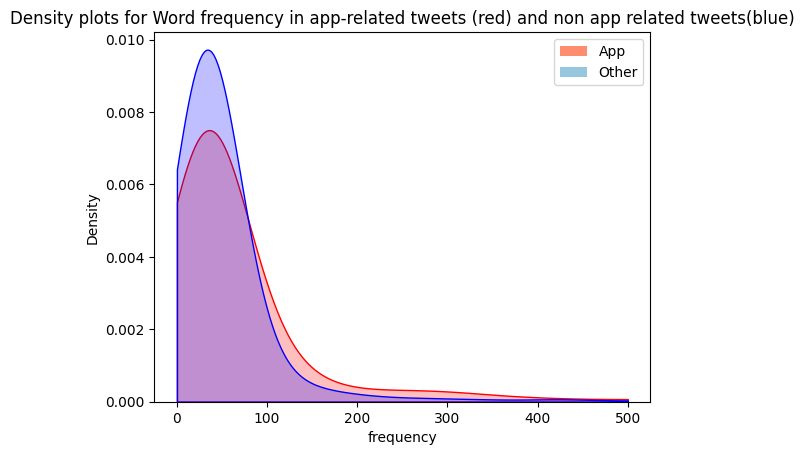

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as  mpatches

long = appFile['frequency']
short = otherFile['frequency']
sns.kdeplot(appFile['frequency'], color="red", shade=True, clip=(0,500)).set(title='Density plots for Word frequency in app-related tweets (red) and non app related tweets(blue)')
sns.kdeplot(otherFile['frequency'], color="blue", shade=True, clip=(0,500))
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="App"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Other")]
plt.legend(handles=handles)
plt.show()

As you can see the words frequencies obtained for the two sets are quite similar. This doesn’t mean that it will be impossible to differentiate one class from the other. This simply means that the frequencies in both sets correspond to a similar communication pattern (tweets in english, mostly). <BR>Actually, I cutted the X axis at 500 but there are around 3000 different words on each set, but the frequencies of the long-tail part are really small.<BR>
To classify between the two possibilities, we need to look at the words present in the new tweets, and see where are more frequent among the two distributions. <BR>Let’s go for it.

## Helper functions


I need a function that gives me the probability of any given word in the data frames that I used for the two classes.

In [9]:
import numpy as np

def get_w_prob(word, dataframe):
    prob = dataframe[dataframe.word == word].probability
    if len(prob) > 0:
        return prob.values[0]
    else:
        return math.log(1/math.log(sum(dataframe.frequency)))
    
# for instance:
invlog = np.exp(get_w_prob("#al", appFile)) #inverse of the log
print("Probability: {:.4%}".format(invlog))

Probability: 9.0038%


I also need to compute the **prior probability** of each class

In [10]:
len(appFile)

857

In [11]:
appPrior = math.log(len(appFile) / (len(appFile) + len(otherFile))) # Number of words in app File / Total number of words (sum of the number of words in both files)
print("The prior prob of tweets belonging to the app is = {0:.1%}".format(math.exp(appPrior)))

otherPrior = math.log(len(otherFile) / (len(appFile) + len(otherFile))) # Number of Tweets in words File / Total number of words (sum of the number of words in both files)
print("The prior prob of tweets NOT belonging to the app is = {0:.1%}".format(math.exp(otherPrior)))


The prior prob of tweets belonging to the app is = 48.2%
The prior prob of tweets NOT belonging to the app is = 51.8%


## The Bayesian classifier. 

Let's build the classifier. I'm using a test set with a few tweets (`test.csv`), and the goal is to read them and say if they are about the APP or not. The test set is already labeled with the class each belongs to in the first column. We will loose that information to check if our prediction is OK.

Read a test file, with the category label in V1 and the tweet contents in V2.


In [12]:
test = pd.read_csv("data/test.csv", header = None, names=["label", "content"])

Now, let's loop through the file to compute the **MAP (maximum A Posterior Probability)** and thus, determine which class the tweet belongs to:

In [13]:
pred = []

for j in range(0,len(test)):
    tweet = test.iloc[j].content # Extract the content of the tweet
    print("Processing tweet:",tweet)
    wordsInThisTweet = ' '.join(tweet.split()).strip().split(" ") # Store the words into a list
    appProb = 0.0
    otherProb = 0.0
    
    # For every word in this tweet, sum its frequency value by using the function defined above
    for word in wordsInThisTweet:
        appProb = appProb + get_w_prob(word, appFile)
        otherProb = otherProb + get_w_prob(word, otherFile)
        
    posteriorAppPob = appProb * appPrior
    posteriorOtherPob = otherProb * otherPrior
    
    # Categorize according to the score obtained from every subset (App tweets, and Other tweets)
    if posteriorAppPob > posteriorOtherPob:
        print("Prediction = {} | Actual Label= {}".format("APP", test.iloc[j].label))
        print()
        pred.append("APP")
    else:
        print("Prediction = {} | Actual Label= {}".format("OTHER", test.iloc[j].label))
        print()
        pred.append("OTHER")

Processing tweet:  just love @mandrillapp transactional email service - http://mandrill.com sorry @sendgrid and @mailjet #timetomoveon
Prediction = APP | Actual Label= APP

Processing tweet:  @rossdeane mind submitting a request at http://help.mandrill.com with account details if you haven't already  glad to take a look 
Prediction = APP | Actual Label= APP

Processing tweet:  @veroapp any chance you'll be adding mandrill support to vero 
Prediction = APP | Actual Label= APP

Processing tweet:  @elie__ @camj59 jparle de relai smtp 1 million de mail chez mandrill / mois comparé à 1 million sur lite sendgrid y a pas photo avec mailjet
Prediction = APP | Actual Label= APP

Processing tweet:  would like to send emails for welcome  password resets  payment notifications  etc what should i use  was looking at mailgun/mandrill
Prediction = APP | Actual Label= APP

Processing tweet:  from coworker about using mandrill  "i would entrust email handling to a pokemon".
Prediction = APP | Actual La

Let's now print the confusion matrix

Accuracy = 80.0%

Confusion Matrix


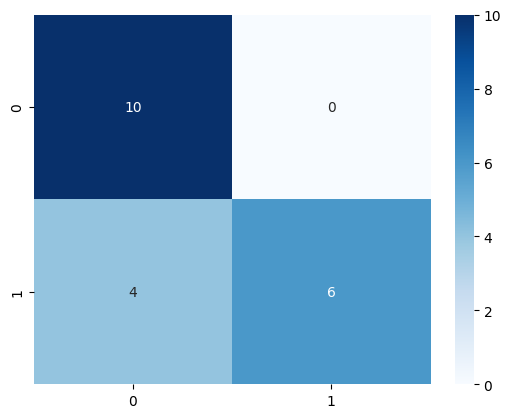

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
print("Accuracy = {0:.1%}".format(accuracy_score(test.label, pred)))
print()

print("Confusion Matrix")
cm = confusion_matrix(test.label, pred)
sn.heatmap(cm, annot=True, cmap=plt.cm.Blues);

A good 80% of Accuracy with this simple implementation